In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# PyTorch
import torch
from torchvision import transforms, datasets, models
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch import optim, cuda

# Visualizations
import matplotlib.pyplot as plt
from skimage import io, transform

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

# Timing utility
from timeit import default_timer as timer


In [3]:
save_file_name = 'efficientnet-transfer-4.pt'
checkpoint_path = 'efficientnet-transfer-4.pth'
earlyStop=300
epochsNo=300

root_dir='/kaggle/input/hc18-ultrasound/HC18/training_set/training_set/'
csv_file='/kaggle/input/hc18-ultrasound/HC18/training_set_pixel_size_and_HC.csv'
img_size = 224
cropped_img = 224
batch_size = 10

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')

Train on gpu: True
1 gpus detected.


In [4]:
HC_df=pd.read_csv(os.path.join(csv_file))

from sklearn.model_selection import train_test_split
HC_df = HC_df[['filename','pixel size(mm)','head circumference (mm)']].drop_duplicates()
HC_df=HC_df[['filename','pixel size(mm)','head circumference (mm)']].copy().rename(columns={'pixel size(mm)':'pixel_size','head circumference (mm)':'HC'})

# HC_df['HC_pixels'] = HC_df['HC'] / HC_df['pixel_size']
# HC_df['normalized_HC_pixels'] = HC_df['HC_pixels'] / 1786.500242
HC_df = HC_df[HC_df.filename.str.contains("_HC")]

train_df, test_val = train_test_split(HC_df, test_size = 0.4,random_state = 2020)
valid_df, test_df = train_test_split(test_val, test_size = 0.5,random_state = 2020)

print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])
# train_df = train_df.groupby(['pixel_size', 'HC']).apply(lambda x: x.sample(4, replace = True)).reset_index(drop = True)
# print('train', train_df.shape[0], 'validation', valid_df.shape[0],'Test',test_df.shape[0])

HC_df.describe()

train 483 validation 161 Test 162


,pixel_size,HC
count,806.000000,806.000000
mean,0.138848,173.971600
std,0.051949,64.761672
min,0.049415,44.300000
25%,0.108393,153.925000
50%,0.128191,174.225000
75%,0.157101,188.797500
max,0.393280,346.400000


(array([1]), <a list of 1 Text major ticklabel objects>)

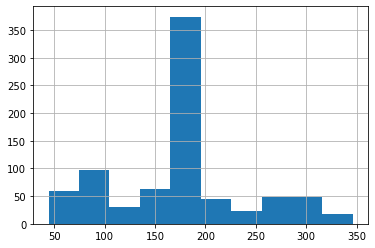

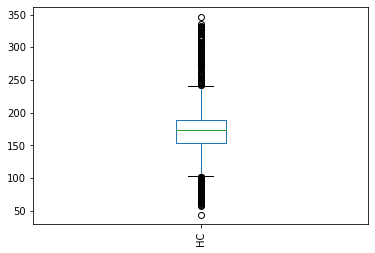

In [5]:
 # plot a histogram  
HC_df['HC'].hist(bins=10)
columns = ['HC']
HC_df[columns].plot.box()
plt.xticks(rotation='vertical')

In [6]:
train_df.to_csv("/kaggle/working/train_file.csv", index=False, encoding='utf8')

valid_df.to_csv("/kaggle/working/val_file.csv", index=False, encoding='utf8')

test_df.to_csv("/kaggle/working/test_file.csv", index=False, encoding='utf8')

In [7]:
# Image manipulations
from PIL import Image

class HC_18(Dataset):
    """Head circumference estimation dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.HC_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.HC_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,self.HC_df.iloc[idx, 0])
        image = Image.open(img_name)
        features = self.HC_df.loc[idx,'HC']
        
        if self.transform:
            image = self.transform(image)
        return image , torch.tensor(features / 346.4)


In [8]:
image_transforms = {
    # Train uses data augmentation
    'train':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.RandomRotation(degrees=10),
            transforms.GaussianBlur(5),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size=cropped_img),  # Image net standards
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    # Validation does not use augmentation
    'val':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    # Test does not use augmentation
    'test':
        transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(size=img_size),
            transforms.CenterCrop(size=cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

In [9]:
train_filename='train_file.csv'
val_filename='val_file.csv'
test_filename='test_file.csv'

data = {'train': HC_18(train_filename ,root_dir = root_dir,transform = image_transforms['train']),
        'val': HC_18(val_filename ,root_dir = root_dir,transform = image_transforms['val']),
        'test': HC_18(test_filename ,root_dir = root_dir,transform = image_transforms['test'])
       }

# Dataloader iterators
dataloaders ={
    'train': DataLoader(data['train'], batch_size=batch_size,shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size,shuffle=False),
    'test': DataLoader(data['test'], batch_size=len(test_df),shuffle=False)
}

torch.Size([10, 3, 224, 224]) torch.Size([10])


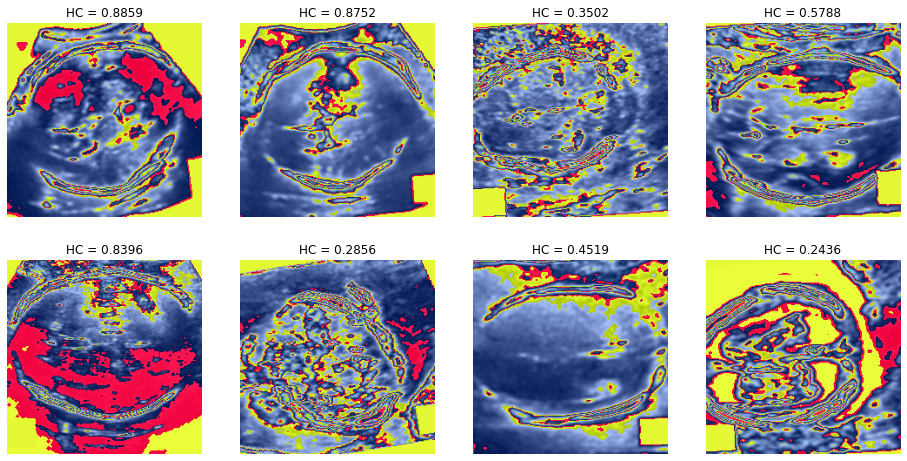

In [10]:
trainiter = iter(dataloaders['train'])
t_x, t_y = next(trainiter)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    trans=transforms.ToPILImage(mode= None)
    c_ax.imshow(trans(c_x))
#     c_y = np.exp(c_y.numpy())
    c_ax.set_title('HC = {:.4f}'.format(c_y.numpy()))
    c_ax.axis('off')


In [11]:
!pip install efficientnet_pytorch

from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b7')


n_inputs = model._fc.in_features
model._fc = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(n_inputs, 1 , bias = True)   
)

# print(model)

if train_on_gpu:
    model = model.to('cuda')


  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16035 sha256=7e52bc3bd609c37fc1c35130c90f24175ad9aa324a98be25a2d90d5fc6160c3e
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
Successfully built efficientnet-pytorch
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth



Loaded pretrained weights for efficientnet-b7


In [12]:
# --------------------------------------Training
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20,print_every=1):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []
    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch...\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0
        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            # Loss and backpropagation of gradients
            loss = criterion(output, target.float())
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Track training progress
            print( f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target.float())
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)
                    
                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                history.append([train_loss, valid_loss])
                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch+1} \tTraining Loss: {train_loss:.4f} \t\tValidation Loss: {valid_loss:.4f}')

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(f'\nEarly Stopping! Total epochs: {epoch+1}. Best epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.')

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch+1} with loss: {valid_loss_min:.2f}')
    print(f'{total_time:.2f} total seconds elapsed. {total_time / (epoch + 1):.2f} seconds per epoch.')
    # Format history
    history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
    return model, history

In [13]:
# --------------------------------------Optimizer
#criterion=nn.MSELoss()
criterion = nn.L1Loss()
# criterion = nn.SmoothL1Loss(beta = 0.5)
optimizer = optim.Adam(model.parameters(),lr=0.0001)

In [14]:
# --------------------------------------Training
model, history = train(model,criterion,optimizer,dataloaders['train'],dataloaders['val'],save_file_name=save_file_name,max_epochs_stop=earlyStop,n_epochs=epochsNo,print_every=1)
history.to_csv("/kaggle/working/history.csv", index=False, encoding='utf8')

Starting Training from Scratch...

Epoch: 1	100.00% complete. 36.40 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.3150 		Validation Loss: 0.1686
Epoch: 2	100.00% complete. 33.99 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2137 		Validation Loss: 0.2117
Epoch: 3	100.00% complete. 32.98 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 0.1994 		Validation Loss: 0.2433
Epoch: 4	100.00% complete. 33.16 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 0.1866 		Validation Loss: 0.2169
Epoch: 5	100.00% complete. 33.27 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 0.1779 		Validation Loss: 0.2237
Epoch: 6	100.00% complete. 32.64 seconds elapsed in epoch.
Epoch: 6 	Training Loss: 0.1762 		Validation Loss: 0.2009
Epoch: 7	100.00% complete. 33.08 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.1652 		Validation Loss: 0.1435
Epoch: 8	100.00% complete. 32.54 seconds elapsed in epoch.
Epoch: 8 	Training Loss: 0.1712 		Validation Loss: 0.1501
Epoch: 9	100.00% complete. 32

Text(0.5, 1.0, 'Training and Validation Losses')

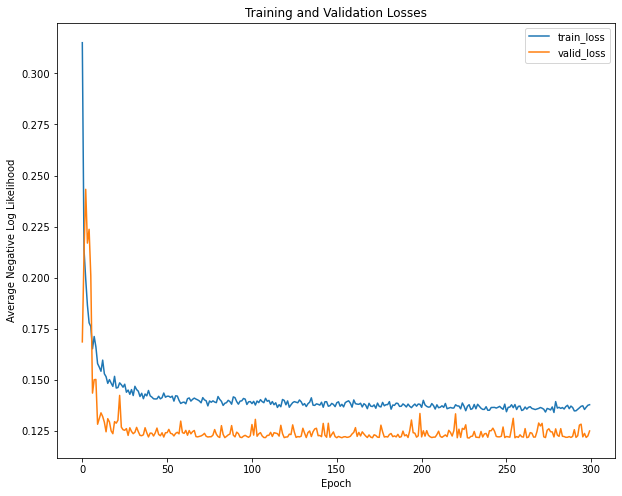

In [15]:
plt.figure(figsize=(10, 8))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label=c)
plt.legend()
plt.xlabel('Epoch',color='k')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

In [16]:
def save_checkpoint(model, path):

    # Basic details
    checkpoint = {
                'epochs': model.epochs
                 }

    # Extract the final classifier and the state dictionary
    checkpoint['fc'] = model._fc
    checkpoint['state_dict'] = model.state_dict()

    # Add the optimizer
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    # Save the data to the path
    torch.save(checkpoint, path)
    

In [17]:
save_checkpoint(model, path=checkpoint_path)

In [18]:

def check_mse_on_test(model, testloader, criterion=None, device='cpu'):  
    """
    Compute the Mean Square Error on the test dataset
    :param model - a pretrained model object
    :param testloader - a generator object representing the test dataset
    :param criterion - loss object
    :param device - a string specifying whether to use cuda or cpu
    return - MSE of predicted head circumference
    """
    loss = 0
    test_loss = 0
    std_mean = 0
    model.eval()
    test_dataframe = pd.read_csv(test_filename)
    with torch.no_grad():
        for data,target in testloader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)

            test_dataframe ['predicted output'] = np.squeeze(output.cpu().numpy())
            test_dataframe.to_csv("/kaggle/working/pred_test_file.csv", index=False, encoding='utf8')

            std_mean = torch.std_mean(output)
            loss = criterion(output, target.float())
            # Multiply average loss times the number of examples in batch
            test_loss += loss.item() * data.size(0)
            
    return std_mean , test_loss / len(testloader.dataset)

In [19]:
criterion = nn.L1Loss()

In [20]:
std_mean , test_loss = check_mse_on_test(model, dataloaders['test'], criterion, device='cuda')
print('Test set MAE loss is {:.4f} Normalized HC pixels'.format(test_loss))
print('Test set std_mean loss is {:.4f} Normalized HC pixels'.format(std_mean[0] * 346.4))
print('Test set MAE loss is {:.4f} HC pixels'.format(test_loss * 346.4))

Test set MAE loss is 0.1213 Normalized HC pixels
Test set std_mean loss is 1.1655 Normalized HC pixels
Test set MAE loss is 42.0325 HC pixels
